# Crop Disease Identification
#### Dataset taken from Kaggle

In [12]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib inline

In [13]:
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,BatchNormalization,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam


### Setting the data directories and loading types of crop diseases

In [51]:
print(f"folder loc: {os.getcwd()}")
data_path = './Dataset'
#disease_types = os.listdir(data_path)
disease_types = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','Potato___Late_blight','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
print(f'Total {len(disease_types)} types of diseases to be identified.')

folder loc: D:\Documents\Python Scripts\Github_Projects\Crop_Disease_Identifiaction
Total 15 types of diseases to be identified.


### Reading training data to pandas dataframe

In [52]:
train_data = []
for d_id, name in enumerate(disease_types):
    for file in os.listdir(os.path.join(data_path,name)):
        train_data.append(['{}/{}'.format(name,file), d_id, name])

train = pd.DataFrame(train_data, columns = ['file', 'disease_id', 'disease_name'])
train.head()
## total files = 20639
## image size = 64 x 64 x3

,file,disease_id,disease_name
0,Pepper__bell___Bacterial_spot/0022d6b7-d47c-4e...,0,Pepper__bell___Bacterial_spot
1,Pepper__bell___Bacterial_spot/006adb74-934f-44...,0,Pepper__bell___Bacterial_spot
2,Pepper__bell___Bacterial_spot/00f2e69a-1e56-41...,0,Pepper__bell___Bacterial_spot
3,Pepper__bell___Bacterial_spot/01613cd0-d3cd-4e...,0,Pepper__bell___Bacterial_spot
4,Pepper__bell___Bacterial_spot/0169b9ac-07b9-4b...,0,Pepper__bell___Bacterial_spot


In [53]:
#defect_files=train['file'][train['Disease_name']=='Pepper__bell___Bacterial_spot'].values
defect_files=train['file'][train['disease_name']=='Tomato_Bacterial_spot'].values

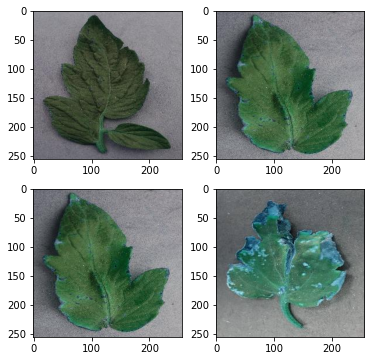

In [54]:
#function takes in disease type and plots nrows*ncols images for it
def plot_leaves(disease_type,nrows,ncols):
    fig, ax = plt.subplots(nrows,ncols, figsize = (6,6))
    def_files = train['file'][train['disease_name'] == disease_type].values
    
    for i in range(nrows):
        for j in range(ncols):
            ax[i,j].imshow(cv2.imread(os.path.join(data_path, def_files[i+j])))
plot_leaves('Tomato_Bacterial_spot',2,2)

In [55]:
train_1 = train.sample(frac = 1.0, random_state = 42)
train_1.reset_index(inplace = True,drop=True)
train_1.head()

,file,disease_id,disease_name
0,Tomato_healthy/9d197d8a-3f35-401a-8aa4-39f7e69...,14,Tomato_healthy
1,Potato___Early_blight/900514b4-8768-4370-bc53-...,2,Potato___Early_blight
2,Tomato_Septoria_leaf_spot/dc5f2f7d-8b86-402e-8...,9,Tomato_Septoria_leaf_spot
3,Tomato_healthy/e3b5600f-9c88-4060-826f-aa7c972...,14,Tomato_healthy
4,Tomato_Leaf_Mold/2e84cbfc-af2c-4c2b-9273-84275...,8,Tomato_Leaf_Mold


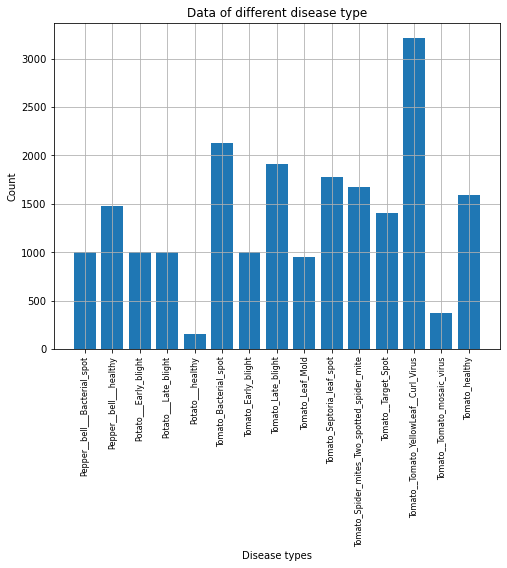

In [101]:
# train_1.groupby('disease_id').count()
plt.figure(figsize=(8, 6))
# plt.hist(train.disease_id,bins = 15)
df1 = train.groupby('disease_id').count()
xticks = disease_types
plt.bar(xticks, df1['disease_name'])
plt.xticks(xticks,rotation = 90, size=8)
plt.xlabel('Disease types')
plt.ylabel('Count')
plt.grid()
plt.title('Data of different disease type')
plt.show()

In [102]:
#function to read image and resize using opncv
def read_image(filepath):
    image = cv2.imread(os.path.join(data_path,filepath))
    return image
def resize_image(image,size):
    return cv2.resize(image.copy(), size, interpolation = cv2.INTER_AREA)

In [104]:
from tqdm import tqdm
image_size = 64
X_data = np.zeros((train_1.shape[0],image_size,image_size,3))
for i, file in tqdm(enumerate(train_1['file'].values)):
    image = read_image(file)
    if image is not None:
        X_data[i]=resize_image(image,(image_size,image_size))
    #print (i)
    #print (file)
X_data=X_data/255.
print ('Data shape = {}'.format(X_data.shape))

20639it [05:29, 62.59it/s]


Data shape = (20639, 64, 64, 3)


In [105]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1562844700633105726
]


In [109]:
y_data=train_1['disease_id'].values
print (y_data.shape)
y_data= tf.keras.utils.to_categorical(y_data,num_classes=15)
print (y_data.shape)

(20639,)
(20639, 15)


In [110]:
SEED = 42
X_train1, X_test, Y_train1, Y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=SEED)
X_train, X_val, Y_train, Y_val = train_test_split(X_train1, Y_train1, test_size=0.2, random_state=SEED)

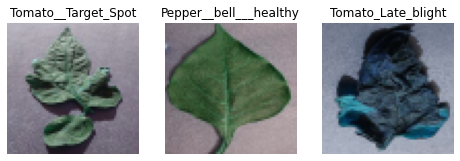

In [115]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

### 1.Simple Artificial neural network with fully connected layers

In [141]:
from time import time
model_1=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (64,64,3)),
    tf.keras.layers.Dense(256, activation='relu',kernel_initializer='HeNormal'),
    tf.keras.layers.Dense(128, activation='relu',kernel_initializer='HeNormal'),
    tf.keras.layers.Dense(15, activation='softmax')
])
opt = tf.keras.optimizers.Adam(learning_rate=0.003)
model_1.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
t0 = time()
history = model_1.fit(X_train,Y_train, validation_data=(X_val, Y_val),epochs=100)
print ("training time: ", round(time()-t0, 3), "s")
model_1.evaluate(X_val,Y_val)

Epoch 1/100
413/413 [==============================] - 7s 16ms/step - loss: 2.2616 - accuracy: 0.2720 - val_loss: 1.9341 - val_accuracy: 0.3533
Epoch 2/100
413/413 [==============================] - 6s 14ms/step - loss: 1.7744 - accuracy: 0.4313 - val_loss: 1.7747 - val_accuracy: 0.4420
Epoch 3/100
413/413 [==============================] - 6s 15ms/step - loss: 1.5497 - accuracy: 0.5005 - val_loss: 1.4286 - val_accuracy: 0.5583
Epoch 4/100
413/413 [==============================] - 7s 17ms/step - loss: 1.4042 - accuracy: 0.5504 - val_loss: 1.3567 - val_accuracy: 0.5671
Epoch 5/100
413/413 [==============================] - 7s 17ms/step - loss: 1.3091 - accuracy: 0.5772 - val_loss: 1.2954 - val_accuracy: 0.5849
Epoch 6/100
413/413 [==============================] - 7s 18ms/step - loss: 1.2385 - accuracy: 0.6023 - val_loss: 1.3061 - val_accuracy: 0.5761
Epoch 7/100
413/413 [==============================] - 7s 18ms/step - loss: 1.1666 - accuracy: 0.6269 - val_loss: 1.1407 - val_accuracy:

413/413 [==============================] - 7s 16ms/step - loss: 0.2023 - accuracy: 0.9360 - val_loss: 0.8502 - val_accuracy: 0.7499
Epoch 58/100
413/413 [==============================] - 7s 16ms/step - loss: 0.1882 - accuracy: 0.9427 - val_loss: 0.6252 - val_accuracy: 0.8153
Epoch 59/100
413/413 [==============================] - 7s 16ms/step - loss: 0.1811 - accuracy: 0.9414 - val_loss: 0.5896 - val_accuracy: 0.8123
Epoch 60/100
413/413 [==============================] - 7s 17ms/step - loss: 0.2006 - accuracy: 0.9381 - val_loss: 0.7433 - val_accuracy: 0.7932
Epoch 61/100
413/413 [==============================] - 8s 20ms/step - loss: 0.1573 - accuracy: 0.9515 - val_loss: 0.7341 - val_accuracy: 0.7826
Epoch 62/100
413/413 [==============================] - 7s 17ms/step - loss: 0.1788 - accuracy: 0.9437 - val_loss: 0.7158 - val_accuracy: 0.7975
Epoch 63/100
413/413 [==============================] - 7s 17ms/step - loss: 0.1828 - accuracy: 0.9422 - val_loss: 0.6292 - val_accuracy: 0.817

[0.6980820298194885, 0.8253103494644165]

#### The model gives around 80% accuracy on training data and 75% on validation data. Although good start but the results can be improved

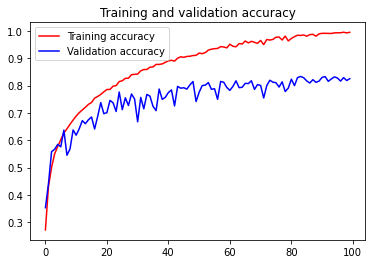

<Figure size 432x288 with 0 Axes>

In [142]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

#### large gap b/w training and validation, so the model is over fitting.

#### Adding regularization to reduce train val error

In [165]:
#Add some regularizarion like batchnorm and dropout
#Normal neural network (without CNN)
from tensorflow.keras import regularizers
model_1_reg=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (64,64,3)),
    tf.keras.layers.Dense(256, activation='relu',kernel_initializer='HeNormal',kernel_regularizer=regularizers.l2(1e-2)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu',kernel_initializer='HeNormal'),#kernel_regularizer=regularizers.l2(1e-3)),#
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(15, activation='softmax')
])
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_1_reg.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
t0 = time()
history_1 = model_1_reg.fit(X_train,Y_train, validation_data=(X_val, Y_val), epochs=30)
print ("training time: ", round(time()-t0, 3), "s")
model_1_reg.evaluate(X_val,Y_val)

Epoch 1/30
413/413 [==============================] - 16s 38ms/step - loss: 3.4717 - accuracy: 0.3298 - val_loss: 2.5175 - val_accuracy: 0.3491
Epoch 2/30
413/413 [==============================] - 16s 39ms/step - loss: 2.0940 - accuracy: 0.4248 - val_loss: 1.8605 - val_accuracy: 0.4817
Epoch 3/30
413/413 [==============================] - 17s 40ms/step - loss: 1.9471 - accuracy: 0.4512 - val_loss: 1.9486 - val_accuracy: 0.4127
Epoch 4/30
413/413 [==============================] - 17s 42ms/step - loss: 1.8109 - accuracy: 0.4889 - val_loss: 1.7326 - val_accuracy: 0.5183
Epoch 5/30
413/413 [==============================] - 17s 42ms/step - loss: 1.7566 - accuracy: 0.5049 - val_loss: 1.7223 - val_accuracy: 0.5268
Epoch 6/30
413/413 [==============================] - 17s 42ms/step - loss: 1.6509 - accuracy: 0.5405 - val_loss: 1.6302 - val_accuracy: 0.5419
Epoch 7/30
413/413 [==============================] - 16s 40ms/step - loss: 1.6548 - accuracy: 0.5392 - val_loss: 1.5230 - val_accuracy:

[1.3403841257095337, 0.6267030239105225]

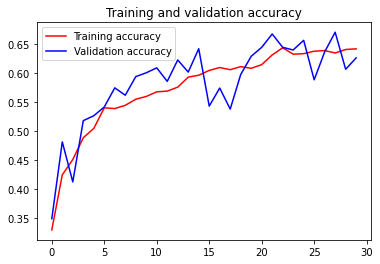

<Figure size 432x288 with 0 Axes>

In [166]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [167]:
#the training slowed down, might need to train for longer for better accuracy in this case

### 2. A simple CNN model

In [168]:
## Simple CNN v1
model_2 = tf.keras.Sequential([
    Conv2D(64,(3,3), activation='relu', input_shape = (64,64,3)),
    MaxPool2D(2,2),
    Conv2D(32,(3,3), activation='relu'),
    MaxPool2D(2,2),
    Conv2D(16,(3,3), activation='relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(15, activation='softmax')
])
opt_2 = tf.keras.optimizers.Adam(learning_rate=0.001)
model_2.compile(optimizer=opt_2, loss='categorical_crossentropy', metrics=['accuracy'])
history_2 = model_2.fit(X_train,Y_train, validation_data=(X_val, Y_val), epochs=30)

####
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

Epoch 1/30
413/413 [==============================] - 194s 469ms/step - loss: 1.9714 - accuracy: 0.3685 - val_loss: 1.5797 - val_accuracy: 0.4956
Epoch 2/30
413/413 [==============================] - 208s 504ms/step - loss: 1.2113 - accuracy: 0.6098 - val_loss: 1.0987 - val_accuracy: 0.6376
Epoch 3/30
413/413 [==============================] - 242s 586ms/step - loss: 0.9067 - accuracy: 0.6944 - val_loss: 0.8367 - val_accuracy: 0.7203
Epoch 4/30
413/413 [==============================] - 254s 616ms/step - loss: 0.7376 - accuracy: 0.7496 - val_loss: 0.7443 - val_accuracy: 0.7536
Epoch 5/30
263/413 [==================>...........] - ETA: 1:16 - loss: 0.6558 - accuracy: 0.7783

KeyboardInterrupt: 

In [178]:
import random
random.seed(42)
a = random.sample(range(1,len(Y_train)), 4000)
X_train_s = X_train[a]
Y_train_s = Y_train[a]
print(len(X_train_s))

4000


Epoch 1/15
125/125 [==============================] - 36s 274ms/step - loss: 1.4531 - accuracy: 0.5537 - val_loss: 4.1674 - val_accuracy: 0.0851
Epoch 2/15
125/125 [==============================] - 39s 313ms/step - loss: 0.7224 - accuracy: 0.7770 - val_loss: 5.7645 - val_accuracy: 0.0869
Epoch 3/15
125/125 [==============================] - 39s 308ms/step - loss: 0.5137 - accuracy: 0.8432 - val_loss: 4.5581 - val_accuracy: 0.1977
Epoch 4/15
125/125 [==============================] - 41s 326ms/step - loss: 0.3666 - accuracy: 0.8878 - val_loss: 2.4788 - val_accuracy: 0.3506
Epoch 5/15
125/125 [==============================] - 40s 318ms/step - loss: 0.2828 - accuracy: 0.9160 - val_loss: 2.3518 - val_accuracy: 0.3751
Epoch 6/15
125/125 [==============================] - 38s 305ms/step - loss: 0.2026 - accuracy: 0.9473 - val_loss: 0.9423 - val_accuracy: 0.7030
Epoch 7/15
125/125 [==============================] - 38s 303ms/step - loss: 0.1596 - accuracy: 0.9600 - val_loss: 1.2432 - val_ac

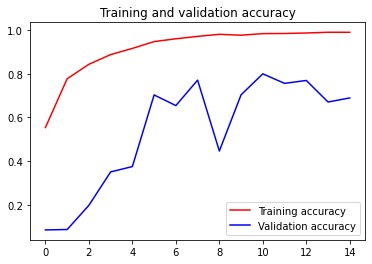

<Figure size 432x288 with 0 Axes>

In [179]:
## Simple CNN v2
model_2a = tf.keras.Sequential([
    Conv2D(64,(3,3), activation='relu',input_shape = (64,64,3)),
    MaxPool2D(2,2),
    BatchNormalization(),
    Conv2D(32,(3,3), activation='relu'),
    MaxPool2D(2,2),
    BatchNormalization(),
    Conv2D(16,(3,3), activation='relu'),
    MaxPool2D(2,2),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(15, activation='softmax')
])
opt_2a = tf.keras.optimizers.Adam(learning_rate=0.001)
model_2a.compile(optimizer=opt_2a, loss='categorical_crossentropy', metrics=['accuracy'])
history_2a = model_2a.fit(X_train_s,Y_train_s, validation_data=(X_val, Y_val), epochs=15)

####
acc = history_2a.history['accuracy']
val_acc = history_2a.history['val_accuracy']
loss = history_2a.history['loss']
val_loss = history_2a.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [186]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',factor=0.5,min_lr=0.0001,patience=5,verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('./model_2_reg.h5',verbose=1,save_best_only=True)
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs= {}):
        if (logs.get('val_accuracy')>0.95):
            print ('\nReached 95% accuracy. So canceling the run')
            self.model.stop_training = True

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)
callbacks=mycallback()
datagen.fit(X_train)
hist = model_2a.fit_generator(datagen.flow(X_train_s, Y_train_s, batch_size=64),
#                steps_per_epoch=X_train.shape[0] // 64,
               epochs=20,
               verbose=2,
               callbacks=[callbacks,reduce_lr, checkpoint],
               validation_data=(X_val, Y_val))

Epoch 1/20
63/63 - 35s - loss: 0.9300 - accuracy: 0.6900 - val_loss: 2.5464 - val_accuracy: 0.5056

Epoch 00001: val_loss improved from inf to 2.54636, saving model to .\model_2_reg.h5
Epoch 2/20
63/63 - 33s - loss: 0.7643 - accuracy: 0.7425 - val_loss: 1.3371 - val_accuracy: 0.6691

Epoch 00002: val_loss improved from 2.54636 to 1.33714, saving model to .\model_2_reg.h5
Epoch 3/20
63/63 - 35s - loss: 0.6908 - accuracy: 0.7680 - val_loss: 1.3204 - val_accuracy: 0.6334

Epoch 00003: val_loss improved from 1.33714 to 1.32039, saving model to .\model_2_reg.h5
Epoch 4/20
63/63 - 37s - loss: 0.6285 - accuracy: 0.7868 - val_loss: 1.1528 - val_accuracy: 0.6718

Epoch 00004: val_loss improved from 1.32039 to 1.15277, saving model to .\model_2_reg.h5
Epoch 5/20
63/63 - 38s - loss: 0.5887 - accuracy: 0.8033 - val_loss: 1.2311 - val_accuracy: 0.6533

Epoch 00005: val_loss did not improve from 1.15277
Epoch 6/20
63/63 - 41s - loss: 0.5857 - accuracy: 0.7980 - val_loss: 0.7099 - val_accuracy: 0.783

In [124]:
model_2 = DenseNet121(weights='imagenet', include_top=False)
input = tf.keras.Input(shape=(64, 64,3))
x = Conv2D(3, (3, 3), padding='same')(input)
    
x = Model_2(x)
    
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(15,activation = 'softmax', name='root')(x)

In [125]:
Model_2_without_BN = DenseNet121(weights='imagenet', include_top=False)
input = tf.keras.Input(shape=(64, 64,3))
x = Conv2D(3, (3, 3), padding='same')(input)
    
x = Model_2(x)
    
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.5)(x)
    # multi output
output = Dense(15,activation = 'softmax', name='root')(x)
for layer in Model_2_without_BN.layers:
    #layer.trainable = False
    layer.trainable = True
Model_2_without_BN = Model(input,output)
Model_2_without_BN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               262400    
_________________________________________________________________
root (Dense)                 (None, 15)                3855      
Total params: 7,303,843
Trainable params: 7,220,195
Non-trainable params: 83,648
______________________________________________

In [187]:
old_model = DenseNet121(weights = 'imagenet', include_top = False)

In [190]:
old

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, None, None, 3 0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_8[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
________________________________________________________________________________________

conv5_block15_0_relu (Activatio (None, None, None, 9 0           conv5_block15_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block15_1_conv (Conv2D)   (None, None, None, 1 122880      conv5_block15_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block15_1_bn (BatchNormal (None, None, None, 1 512         conv5_block15_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block15_1_relu (Activatio (None, None, None, 1 0           conv5_block15_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_block15_2_conv (Conv2D)   (None, None, None, 3 36864       conv5_block15_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_bloc

In [194]:
X_train.shape

(13208, 64, 64, 3)

In [197]:
old_model = DenseNet121(weights = 'imagenet', include_top = False, input_shape = (64,64,3))
for layer in old_model.layers[:-4]:
  layer.trainable = False
for layer in old_model.layers[-4:]:
  layer.trainable = True
model_3 = Sequential()
model_3.add(old_model)
model_3.add(tf.keras.layers.GlobalAveragePooling2D())
model_3.add(tf.keras.layers.Dense(15, activation = 'softmax'))
model_3.compile(optimizer=opt_2a, loss='categorical_crossentropy', metrics=['accuracy'])
history_3 = model_3.fit(X_train,Y_train, validation_data=(X_val, Y_val), epochs=15)

Epoch 1/15
413/413 [==============================] - 286s 663ms/step - loss: 1.1112 - accuracy: 0.6507 - val_loss: 0.7908 - val_accuracy: 0.7502
Epoch 2/15
413/413 [==============================] - 281s 681ms/step - loss: 0.6644 - accuracy: 0.7894 - val_loss: 0.6506 - val_accuracy: 0.7905
Epoch 3/15
303/413 [=====================>........] - ETA: 57s - loss: 0.5676 - accuracy: 0.8193

KeyboardInterrupt: 

In [204]:
old_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (64,64,3))
for layer in old_model.layers[:-4]:
  layer.trainable = False
for layer in old_model.layers[-4:]:
  layer.trainable = True
model_3 = Sequential()
model_3.add(old_model)
model_3.add(tf.keras.layers.GlobalAveragePooling2D())
model_3.add(tf.keras.layers.Dense(512, activation='relu'))
model_3.add(tf.keras.layers.Dense(128, activation='relu'))
model_3.add(tf.keras.layers.Dense(15, activation = 'softmax'))
model_3.compile(optimizer=opt_2a, loss='categorical_crossentropy', metrics=['accuracy'])
history_3 = model_3.fit(X_train_s,Y_train_s, validation_data=(X_val, Y_val), epochs=15)

Epoch 1/15
125/125 [==============================] - 135s 1s/step - loss: 1.9589 - accuracy: 0.3665 - val_loss: 2.7283 - val_accuracy: 0.1726
Epoch 2/15
125/125 [==============================] - 128s 1s/step - loss: 1.5938 - accuracy: 0.4785 - val_loss: 2.4253 - val_accuracy: 0.2004
Epoch 3/15
125/125 [==============================] - 153s 1s/step - loss: 1.4425 - accuracy: 0.5285 - val_loss: 2.4234 - val_accuracy: 0.2104
Epoch 4/15
125/125 [==============================] - 171s 1s/step - loss: 1.3613 - accuracy: 0.5605 - val_loss: 2.3544 - val_accuracy: 0.2764
Epoch 5/15
125/125 [==============================] - 159s 1s/step - loss: 1.2663 - accuracy: 0.5800 - val_loss: 2.2525 - val_accuracy: 0.3282
Epoch 6/15
125/125 [==============================] - 170s 1s/step - loss: 1.2061 - accuracy: 0.5972 - val_loss: 2.1000 - val_accuracy: 0.3515
Epoch 7/15
125/125 [==============================] - 172s 1s/step - loss: 1.1348 - accuracy: 0.6168 - val_loss: 2.1012 - val_accuracy: 0.3939

In [199]:
old_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (64,64,3))

94773248/94765736 [==============================] - 18s 0us/step


In [208]:
import tensorflow_hub as hub
mobilenet = 'https://tfhub.dev/google/imagenet/inception_v2/feature_vector/5'
old_model_1 = hub.KerasLayer(mobilenet, input_shape = (64,64,3), trainable = False)
model_3a = Sequential([
    old_model_1,
    tf.keras.layers.Dense(15, activation = 'softmax'),
])
model_3a.compile(optimizer=opt_2a, loss='categorical_crossentropy', metrics=['accuracy'])
history_3a = model_3a.fit(X_train_s,Y_train_s, validation_data=(X_val, Y_val), epochs=15)


Epoch 1/15
125/125 [==============================] - 68s 483ms/step - loss: 1.6903 - accuracy: 0.4760 - val_loss: 1.2541 - val_accuracy: 0.5970
Epoch 2/15
125/125 [==============================] - 66s 528ms/step - loss: 1.0321 - accuracy: 0.6695 - val_loss: 1.0891 - val_accuracy: 0.6412
Epoch 3/15
125/125 [==============================] - 57s 455ms/step - loss: 0.8952 - accuracy: 0.7035 - val_loss: 1.0216 - val_accuracy: 0.6730
Epoch 4/15
125/125 [==============================] - 50s 405ms/step - loss: 0.8087 - accuracy: 0.7385 - val_loss: 0.9854 - val_accuracy: 0.6794
Epoch 5/15
125/125 [==============================] - 50s 398ms/step - loss: 0.7464 - accuracy: 0.7620 - val_loss: 0.9353 - val_accuracy: 0.6972
Epoch 6/15
125/125 [==============================] - 49s 398ms/step - loss: 0.7032 - accuracy: 0.7785 - val_loss: 0.9258 - val_accuracy: 0.6988
Epoch 7/15
125/125 [==============================] - 47s 378ms/step - loss: 0.6643 - accuracy: 0.7865 - val_loss: 0.9037 - val_ac

In [212]:
import tensorflow_hub as hub
efficientnet = 'https://tfhub.dev/google/efficientnet/b3/feature-vector/1'
old_model_2 = hub.KerasLayer(efficientnet, input_shape = (64,64,3), trainable = False)
for layer in old_model_2.layers[:-4]:
    layer.trainable = False
for layer in old_model_2.layers[-4:]:
    layer.trainable = True
model_3b = Sequential([
    old_model_2,
    tf.keras.layers.Dense(15, activation = 'softmax'),
])
model_3b.compile(optimizer=opt_2a, loss='categorical_crossentropy', metrics=['accuracy'])
history_3b = model_3b.fit(X_train_s,Y_train_s, validation_data=(X_val, Y_val), epochs=15)

AttributeError: 'KerasLayer' object has no attribute 'layers'

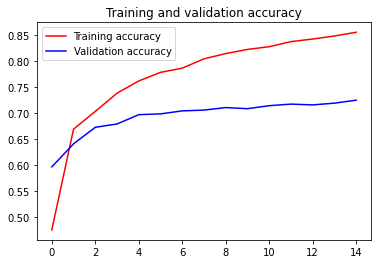

<Figure size 432x288 with 0 Axes>

In [210]:
acc = history_3a.history['accuracy']
val_acc = history_3a.history['val_accuracy']
loss = history_3a.history['loss']
val_loss = history_3a.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

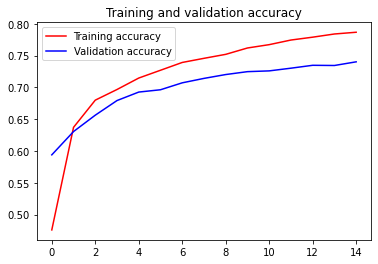

<Figure size 432x288 with 0 Axes>

In [211]:
acc = history_3b.history['accuracy']
val_acc = history_3b.history['val_accuracy']
loss = history_3b.history['loss']
val_loss = history_3b.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [219]:
from tensorflow.keras.applications.resnet50 import ResNet50
Model_resnet = ResNet50(weights='imagenet', include_top=False)

res_mod = tf.keras.Sequential([
    Conv2D(3, (3, 3), padding='same', input_shape = (64,64,3)),
    Model_resnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(15,activation = 'softmax', name='root')
])
# res_mod.summary()

res_mod.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
t0=time()
res_mod.fit(X_train,Y_train, epochs=15)
print ("Training time: ", round((time()-t0),3))
res_mod.evaluate(X_val,Y_val)

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 64, 64, 3)         84        
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dense_94 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_95 (Dense)             (None, 256)               131328    
_________________________________________________________________
root (Dense)                 (None, 15)                3855      
Total params: 24,772,067
Trainable params: 24,718,947
Non-trainable params: 53,120
____________________________________

KeyboardInterrupt: 

In [220]:
type(X_train)

numpy.ndarray

In [221]:
X_train.shape

(13208, 64, 64, 3)

In [222]:
X_data.shape

(20639, 64, 64, 3)

In [223]:
from numpy import savez_compressed, load
savez_compressed('X_data.npz', X_data)

In [224]:
load_data = load('X_data.npz')